In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Reading the data
df = pd.read_csv("/content/drive/MyDrive/spring2025/475 lab spring25/Lab 9/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As we can see that the dataset contains three unnamed columns with null values. So we drop those columns and rename the columns v1 and v2 to label and Text, respectively. Since the target variable is in string form, we will encode it numerically using pandas function .map().

In [4]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Let’s visualize the distribution of Ham and Spam data.

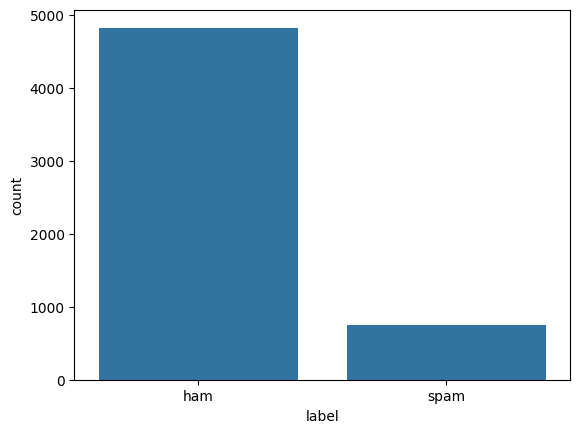

In [5]:
sns.countplot(x=df['label'])
plt.show()

he ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [6]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [7]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [8]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

#MODEL

First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)

Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

#1. Baseline Model

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [10]:
nb_accuracy = accuracy_score(y_test,baseline_model.predict(X_test_vec))
print("Baseline Model Accuracy: ",nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

Baseline Model Accuracy:  0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



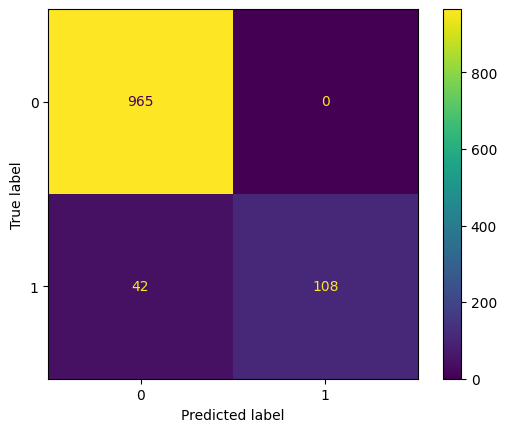

In [11]:
ConfusionMatrixDisplay.from_estimator(baseline_model,X_test_vec,y_test)

#2. Creating custom Text vectorization and embedding layers

Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.;

A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

In [12]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

MAXTOKENS is the maximum size of the vocabulary which was found earlier

OUTPUTLEN is the length to which the sentences should be padded irrespective of the sentence length.

In [13]:
sample_sentence = "This is a sample sentence"
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  41,   10,    5,    1, 2735,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

Now let’s create an embedding layer

In [14]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


input_dim is the size of vocabulary

output_dim is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedded

input_length is the length of input sequences

In [15]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [16]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,994,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,999,041 (7.63 MB)

 Trainable params: 1,999,041 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [18]:
history_1 = model_1.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test), validation_steps = int(0.2*len(X_test)))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8673 - loss: 0.6218 - val_accuracy: 0.9704 - val_loss: 0.5782
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9857 - loss: 0.5713 - val_accuracy: 0.9839 - val_loss: 0.5743
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9949 - loss: 0.5660 - val_accuracy: 0.9830 - val_loss: 0.5730
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9981 - loss: 0.5643 - val_accuracy: 0.9812 - val_loss: 0.5732
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9988 - loss: 0.5636 - val_accuracy: 0.9821 - val_loss: 0.5727


<Axes: >

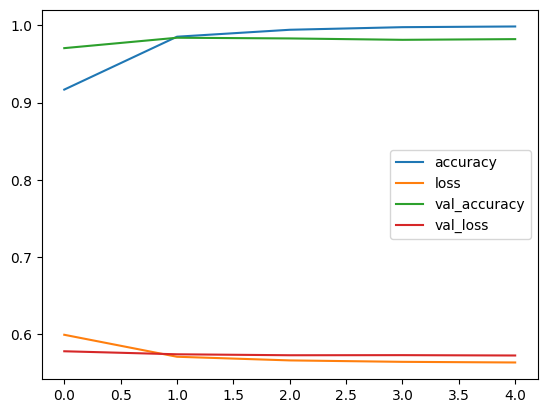

In [19]:
pd.DataFrame(history_1.history).plot()